In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
data_ready = pd.read_csv("data_ready.csv")

In [5]:
data_ready[data_ready.select_dtypes(include=['float64']).columns] = data_ready.select_dtypes(include=['float64']).astype("float32")

In [6]:
data_ready = data_ready.sample(frac=1)

In [7]:
# 70% training data, 15% validation, 15% test
train_dev, test = train_test_split(data_ready, test_size=0.15, random_state=42)
train, dev = train_test_split(train_dev, test_size=0.176, random_state=42)

In [8]:
# # Step 1: Separate majority and minority classes
# minority_class = train[train['5YR_SURV'] == 0]  # Adjust the condition based on your class labels
# majority_class = train[train['5YR_SURV'] == 1]

# # Step 2: Duplicate (oversample) the minority class
# oversample_minority = minority_class.sample(n=len(majority_class), replace=True)

# # Step 3: Combine the majority class with the oversampled minority class
# balanced_df = pd.concat([majority_class, oversample_minority])

# # Shuffle the dataset to mix up the rows
# train = balanced_df.sample(frac=1).reset_index(drop=True)

In [9]:
# convert to tensors and extract labels

train_label = train.pop("5YR_SURV")
dev_label = dev.pop("5YR_SURV")
test_label = test.pop("5YR_SURV")

train_tf = tf.convert_to_tensor(train)
dev_tf = tf.convert_to_tensor(dev)
test_tf = tf.convert_to_tensor(test)

train_label_tf = tf.convert_to_tensor(train_label)
dev_label_tf = tf.convert_to_tensor(dev_label)
test_label_tf = tf.convert_to_tensor(test_label)

In [18]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

# Train an uncalibrated model
rf = RandomForestClassifier()
rf.fit(train, train_label)

# Calibrate the model
calibrated_rf = CalibratedClassifierCV(rf, method='isotonic')  # or method='sigmoid' for Platt scaling
calibrated_rf.fit(train, train_label)

# Get calibrated predictions
y_probs_calibrated = calibrated_rf.predict_proba(test)[:, 1]
y_pred_calibrated = (y_probs_calibrated >= 0.68).astype(int)


In [25]:
from sklearn.metrics import classification_report, roc_auc_score

# Get calibrated predictions
y_probs_calibrated = calibrated_rf.predict_proba(test)[:, 1]
y_pred_calibrated = (y_probs_calibrated >= 0.74).astype(int)

print("Classification Report:")
print(classification_report(test_label, y_pred_calibrated))
print("ROC AUC Score:", roc_auc_score(test_label, y_pred_calibrated))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.36      0.60      0.45       993
         1.0       0.80      0.59      0.68      2601

    accuracy                           0.60      3594
   macro avg       0.58      0.60      0.57      3594
weighted avg       0.68      0.60      0.62      3594

ROC AUC Score: 0.5979166739262497


In [11]:
model = tf.keras.Sequential(
    [
       tf.keras.Input(shape=(214,)),
       tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.006), name="L19"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.006), name="L7"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.006), name="L1"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.006), name="L3"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.006), name="L15"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.006), name="L5"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.006), name="L9"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.006), name="L11"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(1, activation="sigmoid", name="L13") 
    ]
)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [14]:
from sklearn.utils import class_weight
y_train = np.array(train_label_tf)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert the class weights into a dictionary with class labels as keys
# class_weight_dict = dict(enumerate(class_weights))
class_weight_dict = {0:3,1:0.7}

In [15]:
history = model.fit(train_tf, train_label_tf, epochs=1000, batch_size=2048, callbacks=[early_stopping], validation_data = (dev_tf, dev_label_tf))

Epoch 1/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - accuracy: 0.4956 - auc: 0.4899 - loss: 15.7625 - recall: 0.4982 - val_accuracy: 0.7068 - val_auc: 0.5264 - val_loss: 15.2894 - val_recall: 0.9673
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.5039 - auc: 0.5014 - loss: 15.6488 - recall: 0.5044 - val_accuracy: 0.7155 - val_auc: 0.5258 - val_loss: 15.2005 - val_recall: 1.0000
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.5029 - auc: 0.4966 - loss: 15.5646 - recall: 0.5122 - val_accuracy: 0.7155 - val_auc: 0.5248 - val_loss: 15.1146 - val_recall: 1.0000
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.4988 - auc: 0.4947 - loss: 15.4712 - recall: 0.5032 - val_accuracy: 0.7155 - val_auc: 0.5333 - val_loss: 15.0293 - val_recall: 1.0000
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.5012 - auc: 0.4975 - loss: 15.3894 - recall: 0.5028 - val_accuracy: 0.7155 - val_auc: 0.5382 - val_loss: 14.9439 - val_recall: 1.0000


KeyboardInterrupt: 

In [372]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(dev)
y_pred = y_pred.round()
print("Classification Report:")
print(classification_report(dev_label_tf, y_pred))
print("ROC AUC Score:", roc_auc_score(dev_label_tf, y_pred))

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.51      0.04      0.07       956
         1.0       0.74      0.99      0.84      2629

    accuracy                           0.73      3585
   macro avg       0.62      0.51      0.46      3585
weighted avg       0.68      0.73      0.64      3585

ROC AUC Score: 0.5128375808292127


In [373]:
from sklearn.metrics import precision_score, recall_score, f1_score


y_pred = model.predict(dev_tf)
y_pred = y_pred.round()

precision = precision_score(dev_label_tf, y_pred)
recall = recall_score(dev_label_tf, y_pred)
f1 = f1_score(dev_label_tf, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
recall_score(dev_label_tf, y_pred, pos_label=0)

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Precision: 0.74
Recall: 0.99
F1-Score: 0.84


0.0397489539748954

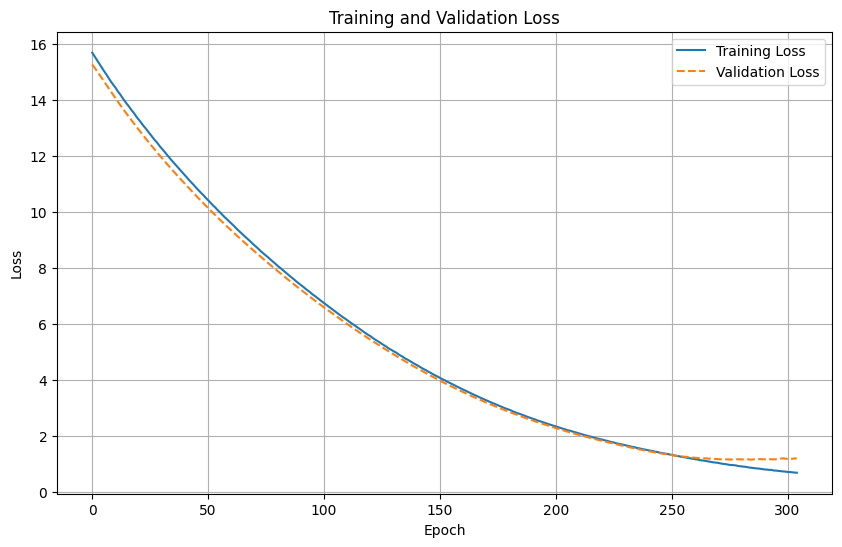

In [374]:
loss_values = history.history['loss']
val_loss_values = history.history.get('val_loss')

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Training Loss')
if val_loss_values:
    plt.plot(val_loss_values, label='Validation Loss', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [375]:
model.evaluate(test_tf, test_label_tf)

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7010 - auc_16: 0.5944 - loss: 1.2277 - recall_16: 0.9784


[1.1940730810165405,
 0.7136895060539246,
 0.9825038909912109,
 0.5991232991218567]

In [376]:
# from xgboost import XGBClassifier

In [377]:
# model = XGBClassifier(n_estimators=500, max_depth=None, subsample=0.7, colsample_bytree=0.7, learning_rate=0.1, reg_alpha=0.1, reg_lambda=1.0, scale_pos_weight=0.33, objective='binary:logistic')
# model.fit(train, train_label)
# print(model.score(train, train_label))
# print(model.score(dev, dev_label))
# y_pred = model.predict(dev)

In [378]:
# from sklearn.metrics import precision_score, recall_score, f1_score

# precision = precision_score(dev_label_tf, y_pred)
# recall = recall_score(dev_label_tf, y_pred)
# f1 = f1_score(dev_label_tf, y_pred)

# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1-Score: {f1:.2f}")

In [379]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0],
#     'reg_alpha': [0.01, 0.1, 1],
#     'reg_lambda': [0.01, 0.1, 1]
# }

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
# grid_search.fit(np.array(train_tf), np.array(train_label_tf))

# print(f"Best Hyperparameters: {grid_search.best_params_}")
# print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")


In [380]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier

# model = LogisticRegression(max_iter=1000)
# model.fit(train_tf, train_label_tf)
# print(f"Logistic Regression Accuracy: {model.score(dev_tf, dev_label_tf) * 100:.2f}%")

# model = RandomForestClassifier(n_estimators=100)
# model.fit(train_tf, train_label_tf)
# print(f"Random Forest Accuracy: {model.score(dev_tf, dev_label_tf) * 100:.2f}%")
# model.predict(dev_tf)


# precision = precision_score(dev_label_tf, y_pred)
# recall = recall_score(dev_label_tf, y_pred)
# f1 = f1_score(dev_label_tf, y_pred)

# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1-Score: {f1:.2f}")
# from sklearn.metrics import recall_score
# recall_score(dev_label_tf, y_pred, pos_label=0)